In [2]:
using CairoMakie, Dierckx, QuantEcon, LinearAlgebra, Optim

In [1]:
pars = (;r = 0.11, # interest rate
    w = 0.015, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    how_iter = 50, # number of Howard iterations
    print_skip = 100, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 15000.0) # upper bound of capital grid

(r = 0.11, w = 0.015, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, θ = 4.0, toler = 4.0e-7, maxiter = 1000, how_iter = 75, print_skip = 100, lb = 0.0, ub = 15000.0)

In [3]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1.0
        return log(c)
    else
        return c^(1-γ)/(1-γ)
    end
end

function ar1(pars)
    (;ρ, μ, σ, nz) = pars
    mc = QuantEcon.rouwenhorst(nz, μ, ρ, σ)
    return mc.p, mc.state_values
end

function exp_grid(pars)
    (; na, θ, lb, ub) = pars
    grid = LinRange(0.0,1.0,na)
    exp_grid = lb .+ (ub - lb) .* grid.^θ
    return exp_grid
end

function resources(Avals, Zvals, j, i, pars)
    (; r, w) = pars
    return (1+r)*Avals[j] + ( w * exp(Zvals[i]) )
end

function interpV(Avals, v_slice)
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    return interp_v
end

function optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
    (; β, na, nz, lb) = pars
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV(Avals, expected_value)
        for j in 1:na
            obj(ap) = - (utility(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))
            ub = resources(Avals, Zvals, j, i, pars)  
            res = optimize(obj, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

function howard(v, policy, Π, Agrid, Zgrid, tuple)
    (; β, na, nz, how_iter) = tuple
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV(Agrid, exp_val)
            for i in 1:na
                obj(ap) = (utility(resources(Agrid, Zgrid, i, j, pars) - ap, pars) + β * interp_e_val(ap))
                v[i,j] = obj(policy[i,j])
            end
        end
    end
    return v
end        

howard (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 1.0
--------------------
Iteration: 100, Error: 5.380467492759879e-6
--------------------
Converged in 126 iterations
--------------------
  1.406056 seconds (2.04 M allocations: 195.839 MiB, 3.81% gc time, 14.48% compilation time)


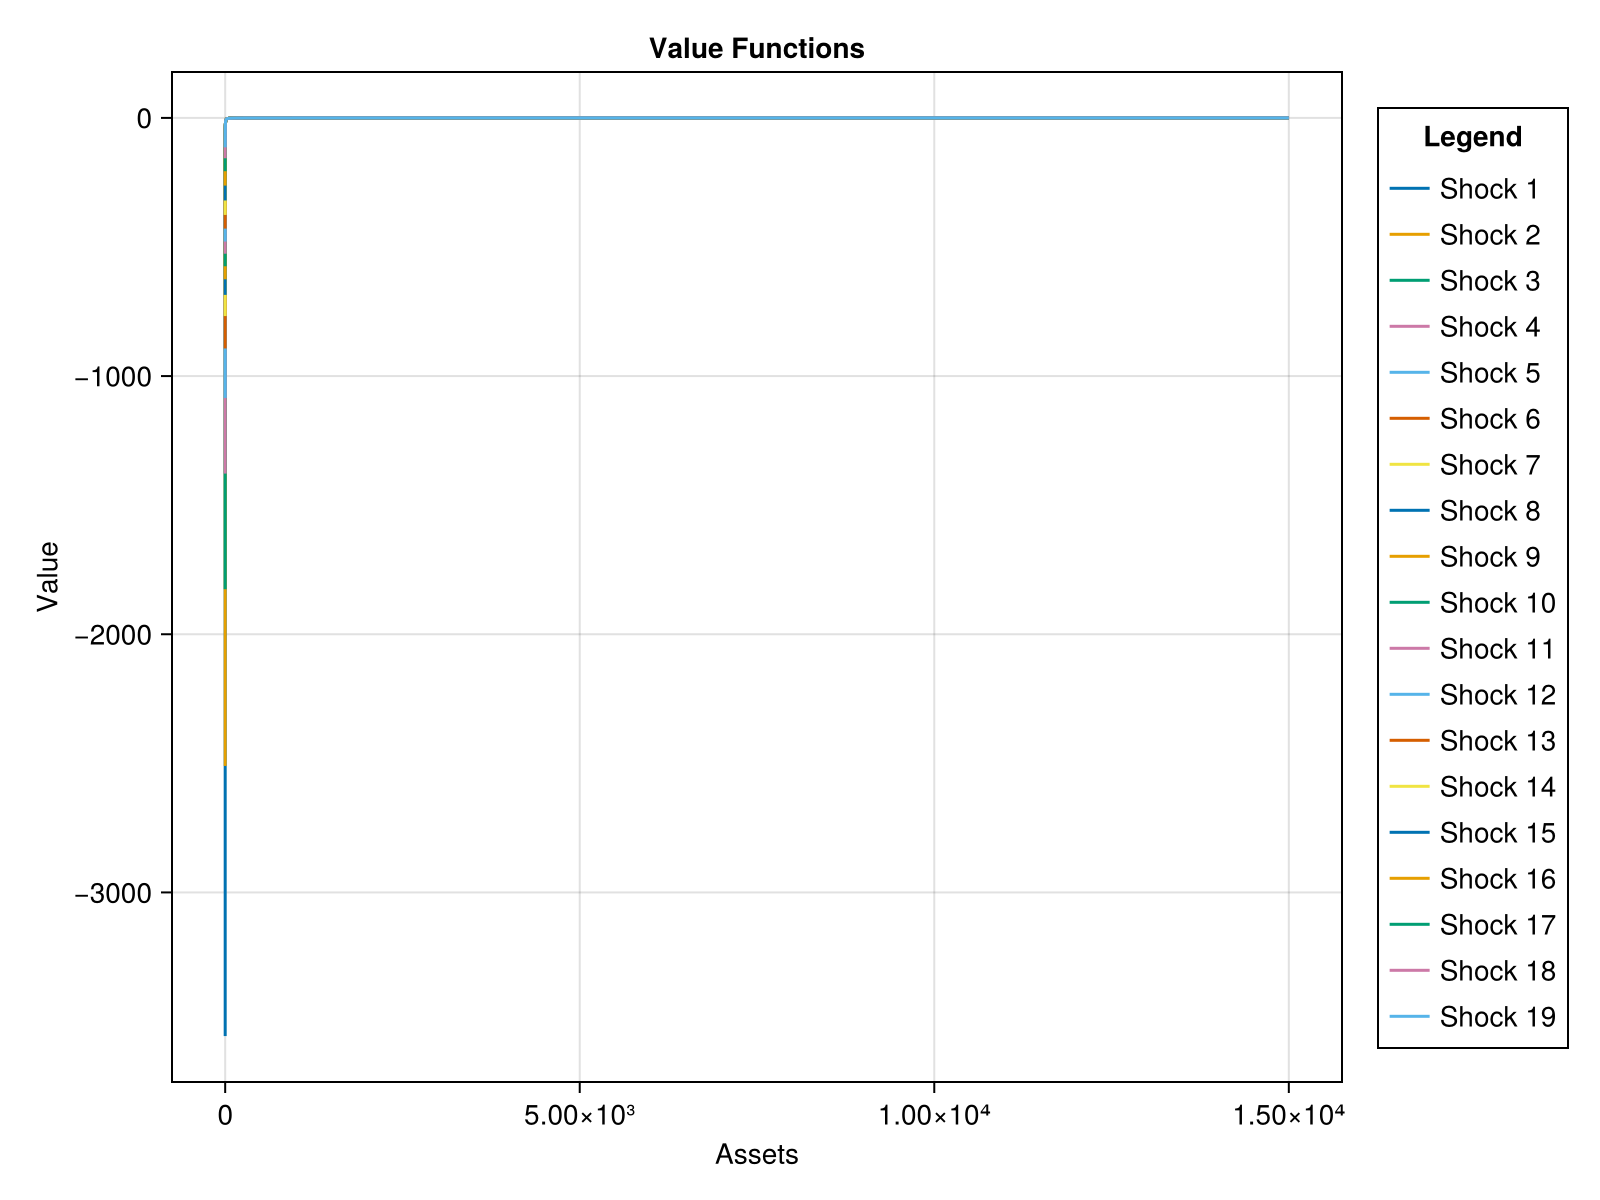

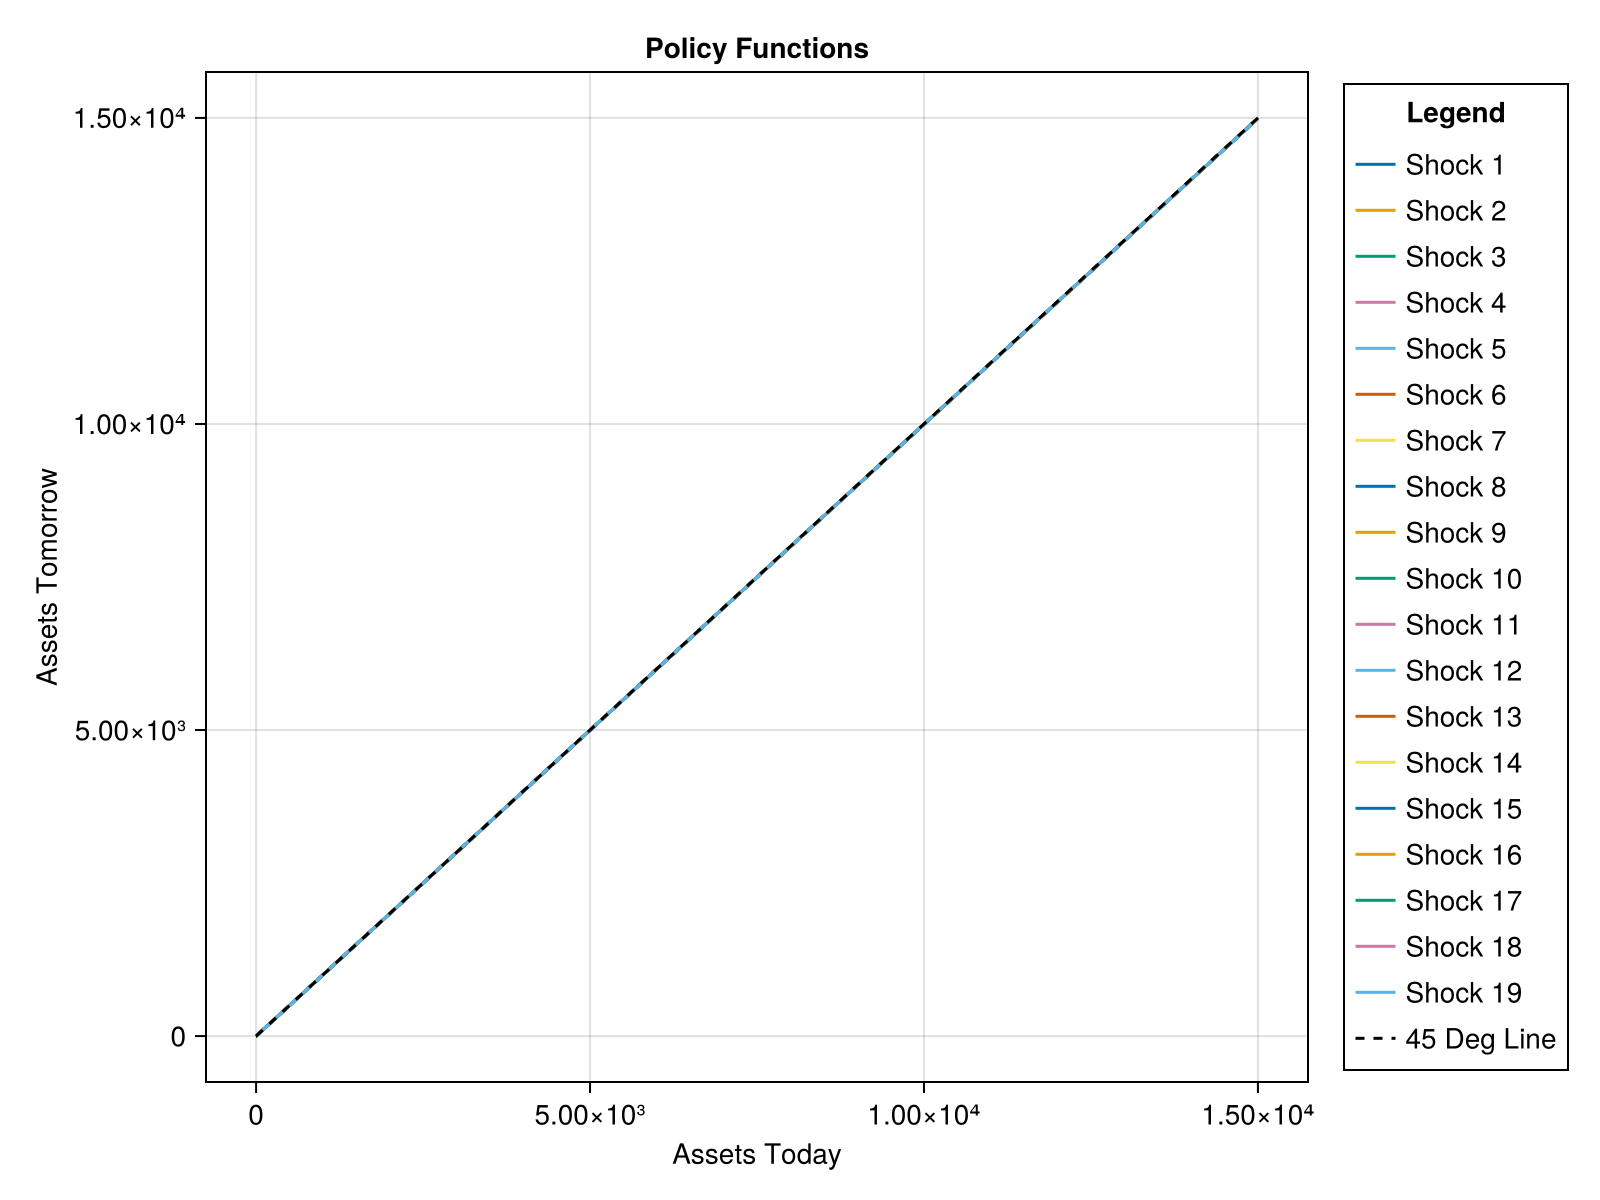

([-3556.484368863616 -2510.159446187564 … -156.2846267364275 -114.08184545134462; -2542.538083517414 -2019.2803938989844 … -156.24380586055344 -114.06045844372119; … ; -0.006307248746544006 -0.006307248677666036 … -0.006307072111974128 -0.006306978701888845; -0.006058661334381402 -0.006058661270808299 … -0.006058498303670867 -0.006058412087550823], [3.0829500473159393e-16 2.801609645960482e-16 … 0.38430790816393895 0.5967801929577115; 2.720136473929327e-16 4.140271117968667e-16 … 0.38445884474089564 0.596930810953213; … ; 14401.659684375043 14401.659841580196 … 14402.062842903879 14402.276055397562; 14992.633665050796 14992.63382226917 … 14993.037467226279 14993.251020393895])

In [5]:
function vfi(v_init, pars)
    (; maxiter, toler, nz, na, print_skip) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v_init = ones(pars.na, pars.nz)
pol_init = ones(pars.na, pars.nz)

@time begin
v_out, pol_out = vfi(v_init, pars)
end

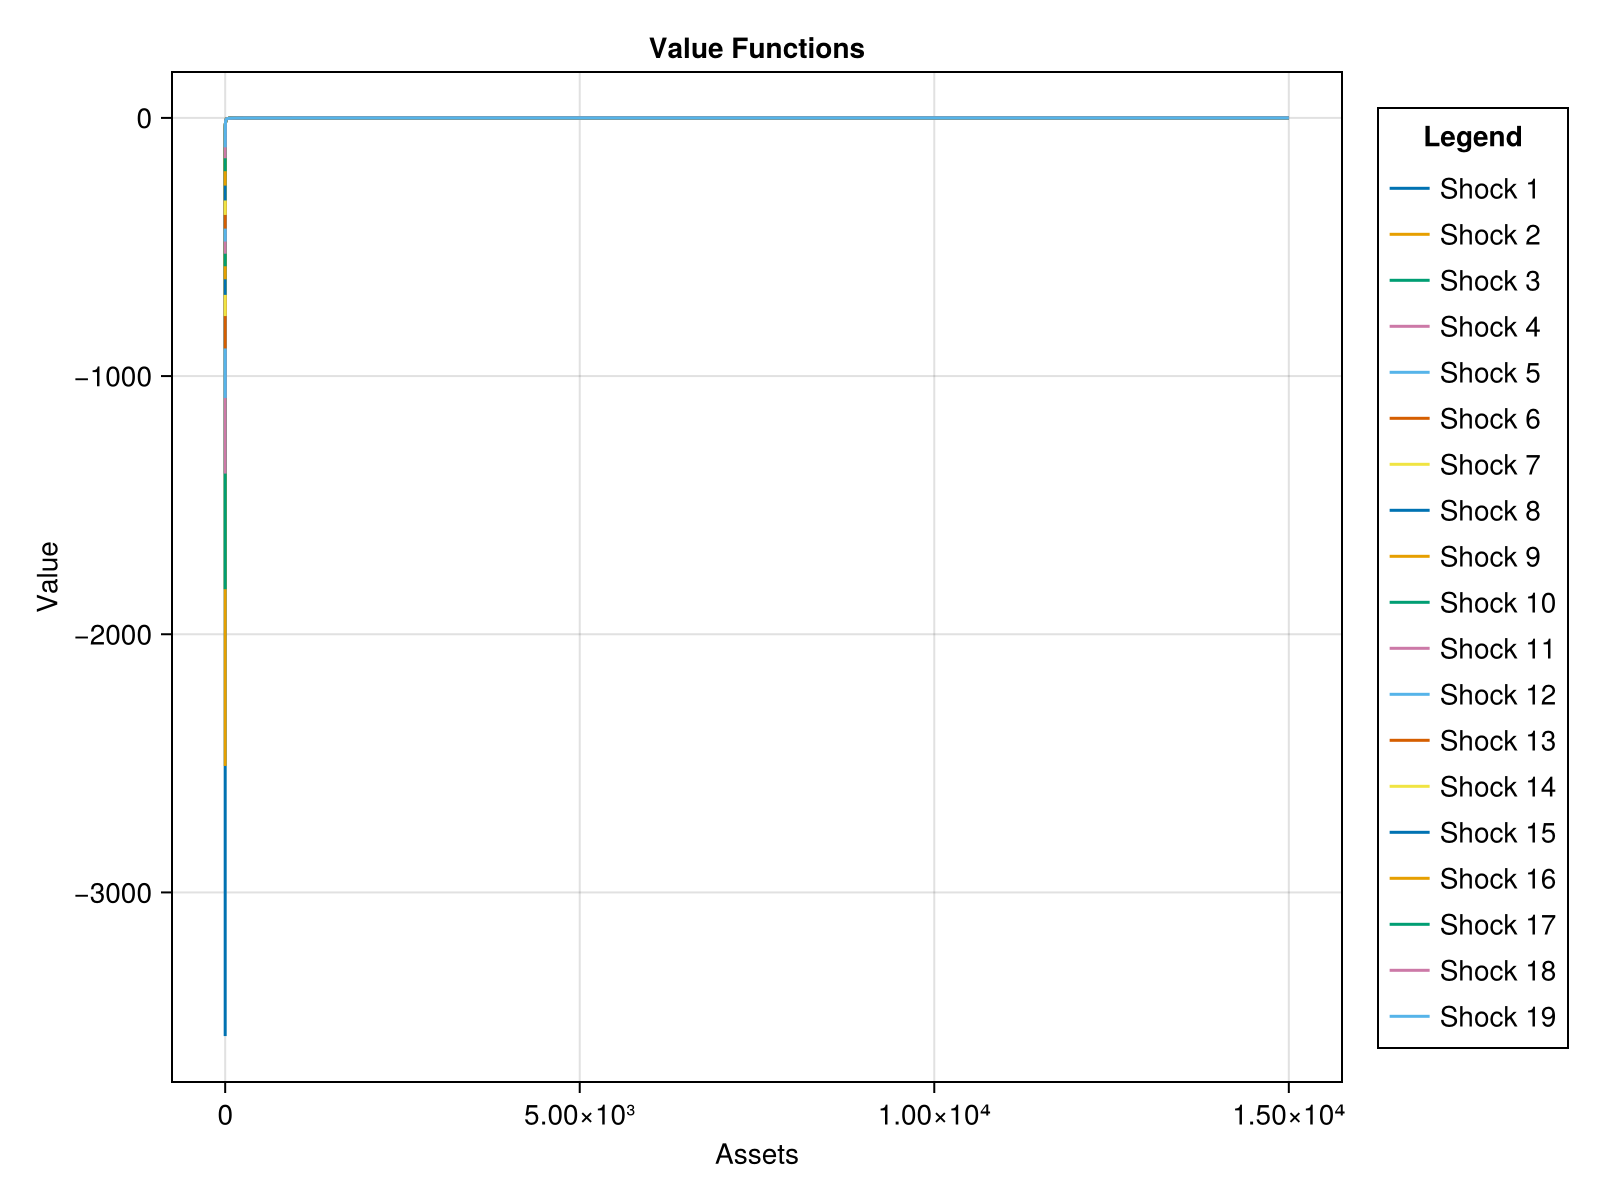

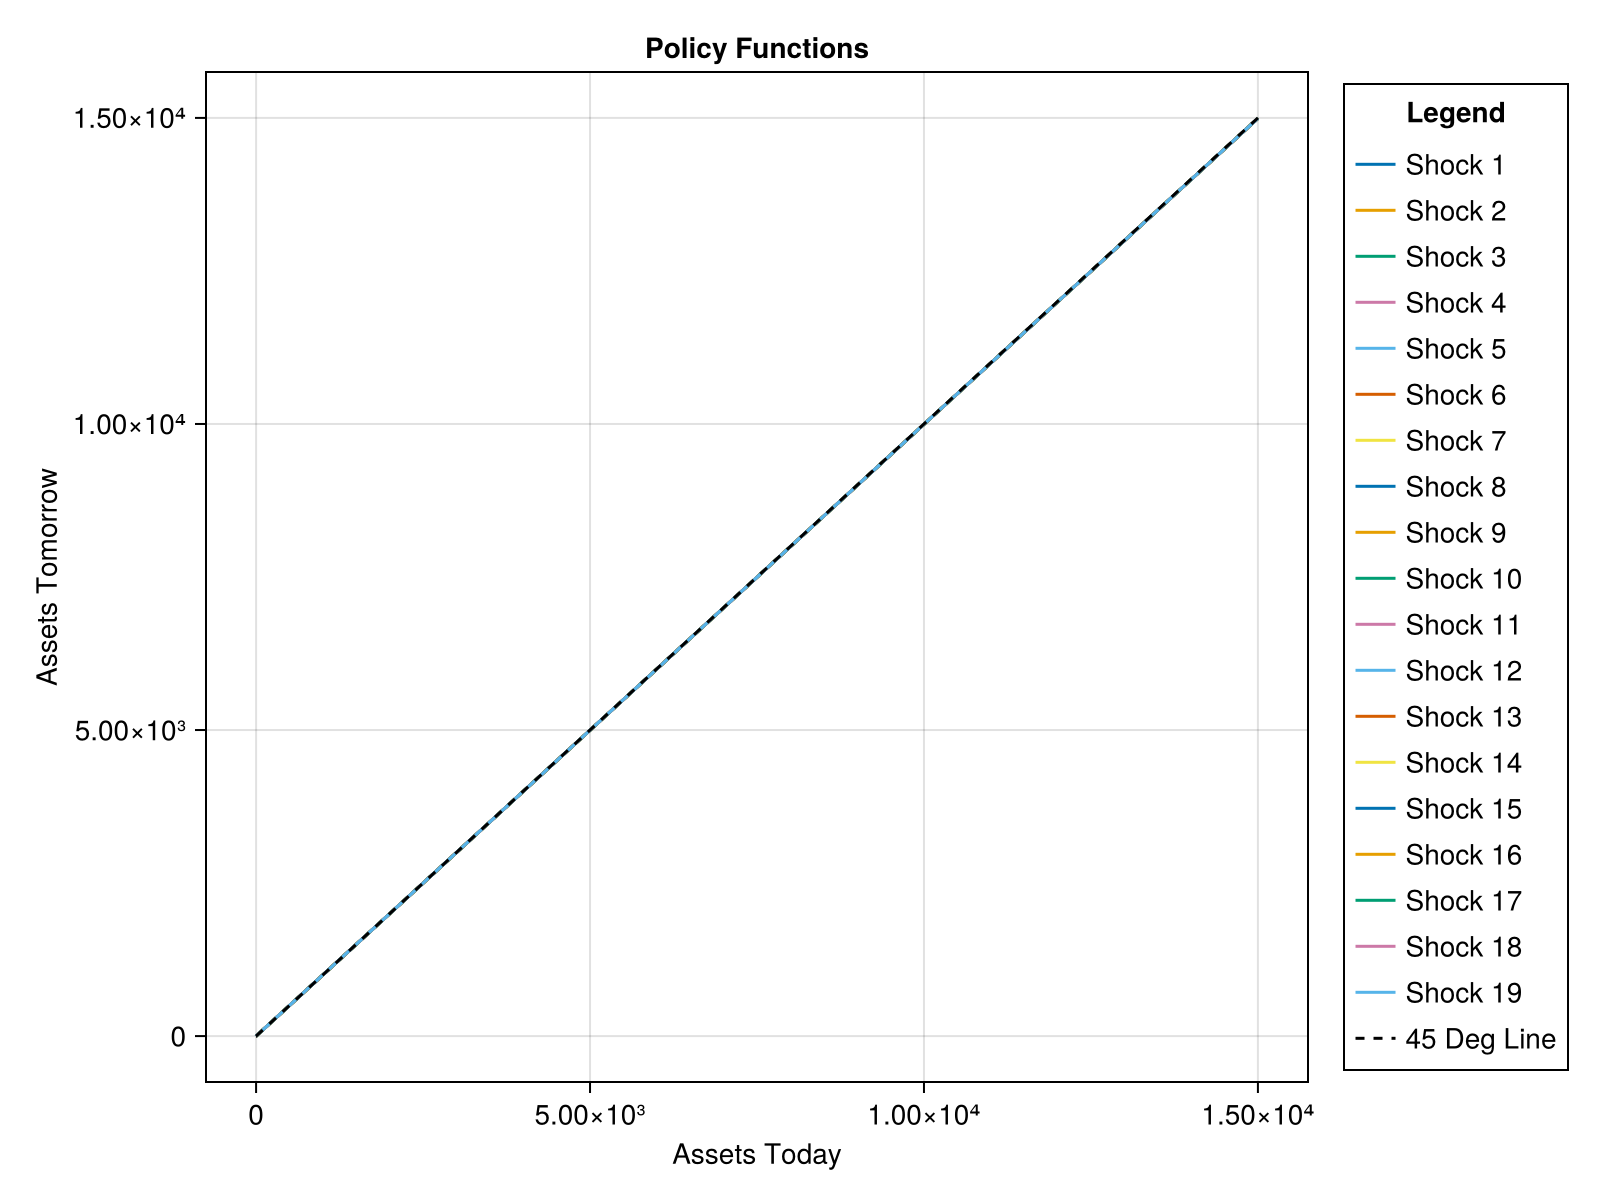

Iterating...
--------------------
Iteration: 0, Error: 2.0228796564817974e-15
--------------------
Converged in 1 iterations
--------------------
  0.807334 seconds (2.56 M allocations: 157.616 MiB, 4.15% gc time, 24.35% compilation time)


([-3556.484913207733 -2510.159990531681 … -156.28506189634234 -114.08220423954123; -2542.5386278615315 -2019.2809382431014 … -156.24424096281157 -114.06081718281541; … ; -0.0063089879667986605 -0.006308987897920442 … -0.006308811331587396 -0.006308717921162925; -0.006060399640974578 -0.006060399577401238 … -0.006060236609652795 -0.006060150393209495], [3.0829500473332825e-16 2.801609645998752e-16 … 0.384307953251689 0.5967802942136637; 2.720136473965797e-16 4.140271118024388e-16 … 0.38445888985138976 0.5969309122137348; … ; 14401.662575149017 14401.662732575454 … 14402.06573389082 14402.27894643716; 14992.636771896476 14992.636929352522 … 14993.04057415272 14993.254127663376])

In [7]:
function hpi(v_init, policy, pars)
    (; maxiter, toler, print_skip) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        v_new = howard(v_new, policy, Π, Avals, Zvals, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end
        
@time begin
    hpi_v, hpi_pol = hpi(v_init, pol_init, pars)
end    

In [8]:
p = (;r = 0.11, # interest rate
    w = 0.015, # wage   
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 31, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    how_iter = 50, # number of Howard iterations
    print_skip = 100, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 15000.0) # upper bound of capital grid

(r = 0.11, w = 0.015, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 31, θ = 4.0, toler = 4.0e-7, maxiter = 1000, how_iter = 50, print_skip = 100, lb = 0.0, ub = 15000.0)

In [9]:
function utility_CES(c, p)
    (; γ) = p
    return c^(1-γ)
end

function interpV_CES(Avals, v_slice, p)
    (; γ) = p
    interp_v = Spline1D(Avals, v_slice, k=1, bc="extrapolate")
    transformed_interp(x) = interp_v(x)^(1.0-p.γ)
    return transformed_interp
end

function optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
    (; β, na, nz, lb, γ) = p
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV_CES(Avals, expected_value, p)
        for j in 1:na
            obj_CES(ap) = - (((1-β) * utility_CES(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))^(1/(1-γ)))
            ub = resources(Avals, Zvals, j, i, p)  
            res = optimize(obj_CES, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

function howard_CES(v, policy, Π, Agrid, Zgrid, p)
    (; β, na, nz, how_iter, γ) = p
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV_CES(Agrid, exp_val, p)
            for i in 1:na
                obj_CES(ap) = (((1-β) * utility_CES(resources(Agrid, Zgrid, i, j, p) - ap, p) + β * interp_e_val(ap)))^(1/(1-γ))
                v[i,j] = obj_CES(policy[i,j])
            end
        end
    end
    return v
end  

howard_CES (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 0.9934324089935621
--------------------
Iteration: 100, Error: 0.004176577796405542
--------------------
Converged in 190 iterations
--------------------
  4.772297 seconds (118.15 M allocations: 2.427 GiB, 3.39% gc time, 13.35% compilation time)


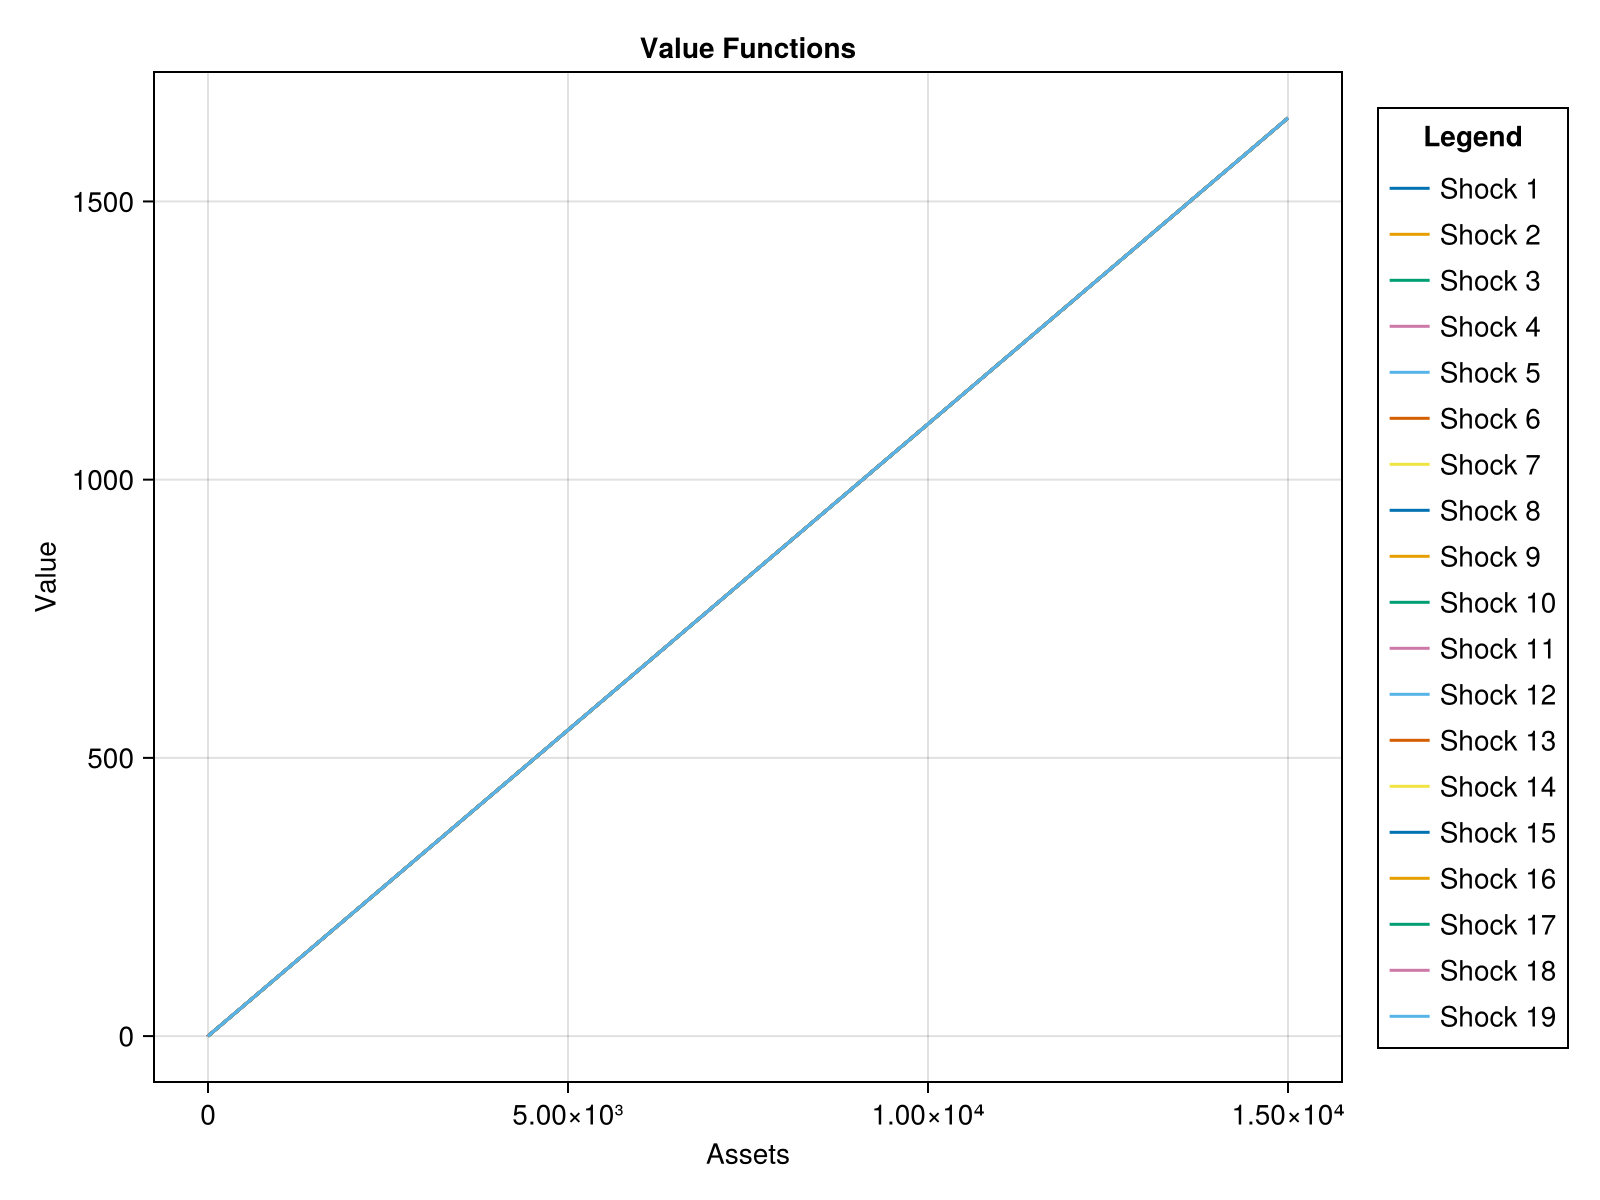

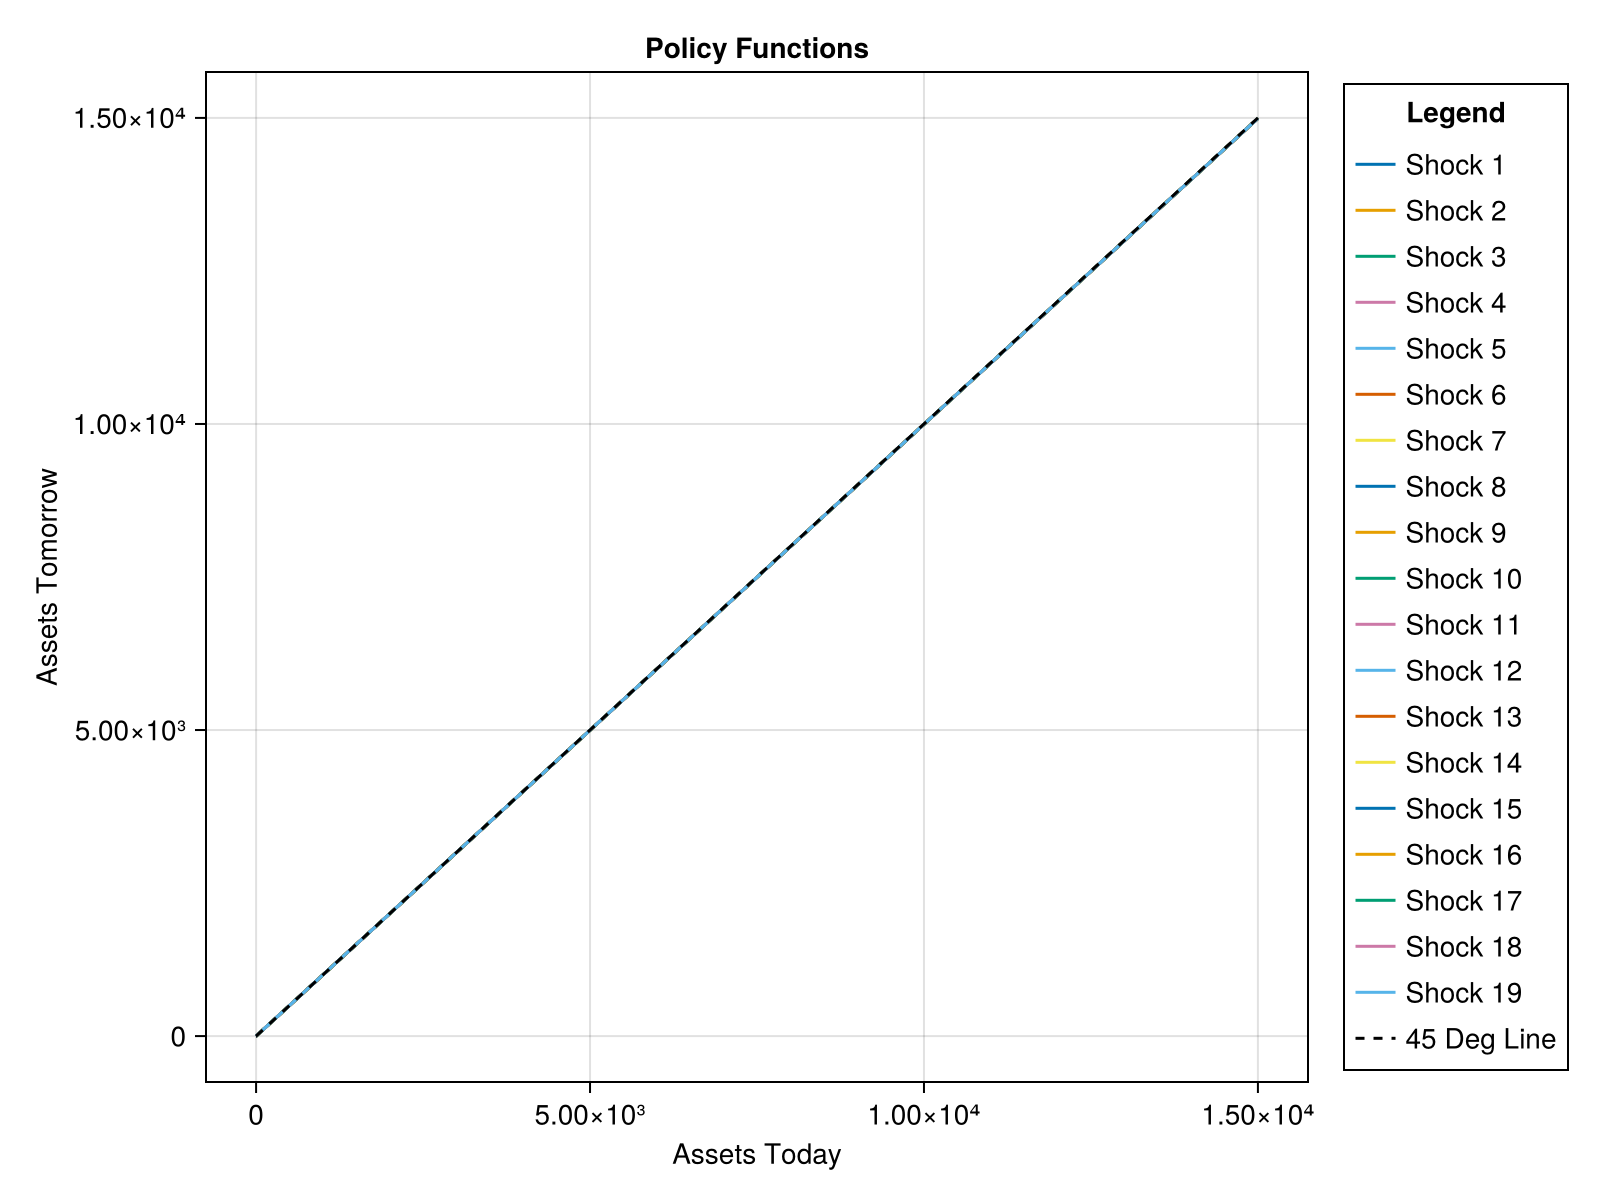

([0.002844878137103036 0.004050609725200679 … 0.06433278314721592 0.08786566058439615; 0.01899284711543443 0.019021851369085175 … 0.06637522356863221 0.08990810100581242; … ; 1440.8064259405412 1440.8064432461872 … 1440.8508067648888 1440.8742777899888; 1650.0522931220974 1650.0523104277306 … 1650.0966739140824 1650.120144922067], [4.043884594224773e-16 3.820028971959754e-16 … 0.3836265718686392 0.5968581533929548; 0.006148812102888511 0.006300933220498831 … 0.40213313907795584 0.6153647212242268; … ; 13091.22598263035 13091.226139500704 … 13091.629235803595 13091.842498494236; 14992.478470559663 14992.478627989261 … 14992.881723745824 14993.094986444881])

In [10]:
function vfi_CES(v_init, p)
    (; maxiter, toler, nz, na, print_skip) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v2 = ones(p.na, p.nz)

@time begin
v_out, pol_out = vfi_CES(v2, p)
end

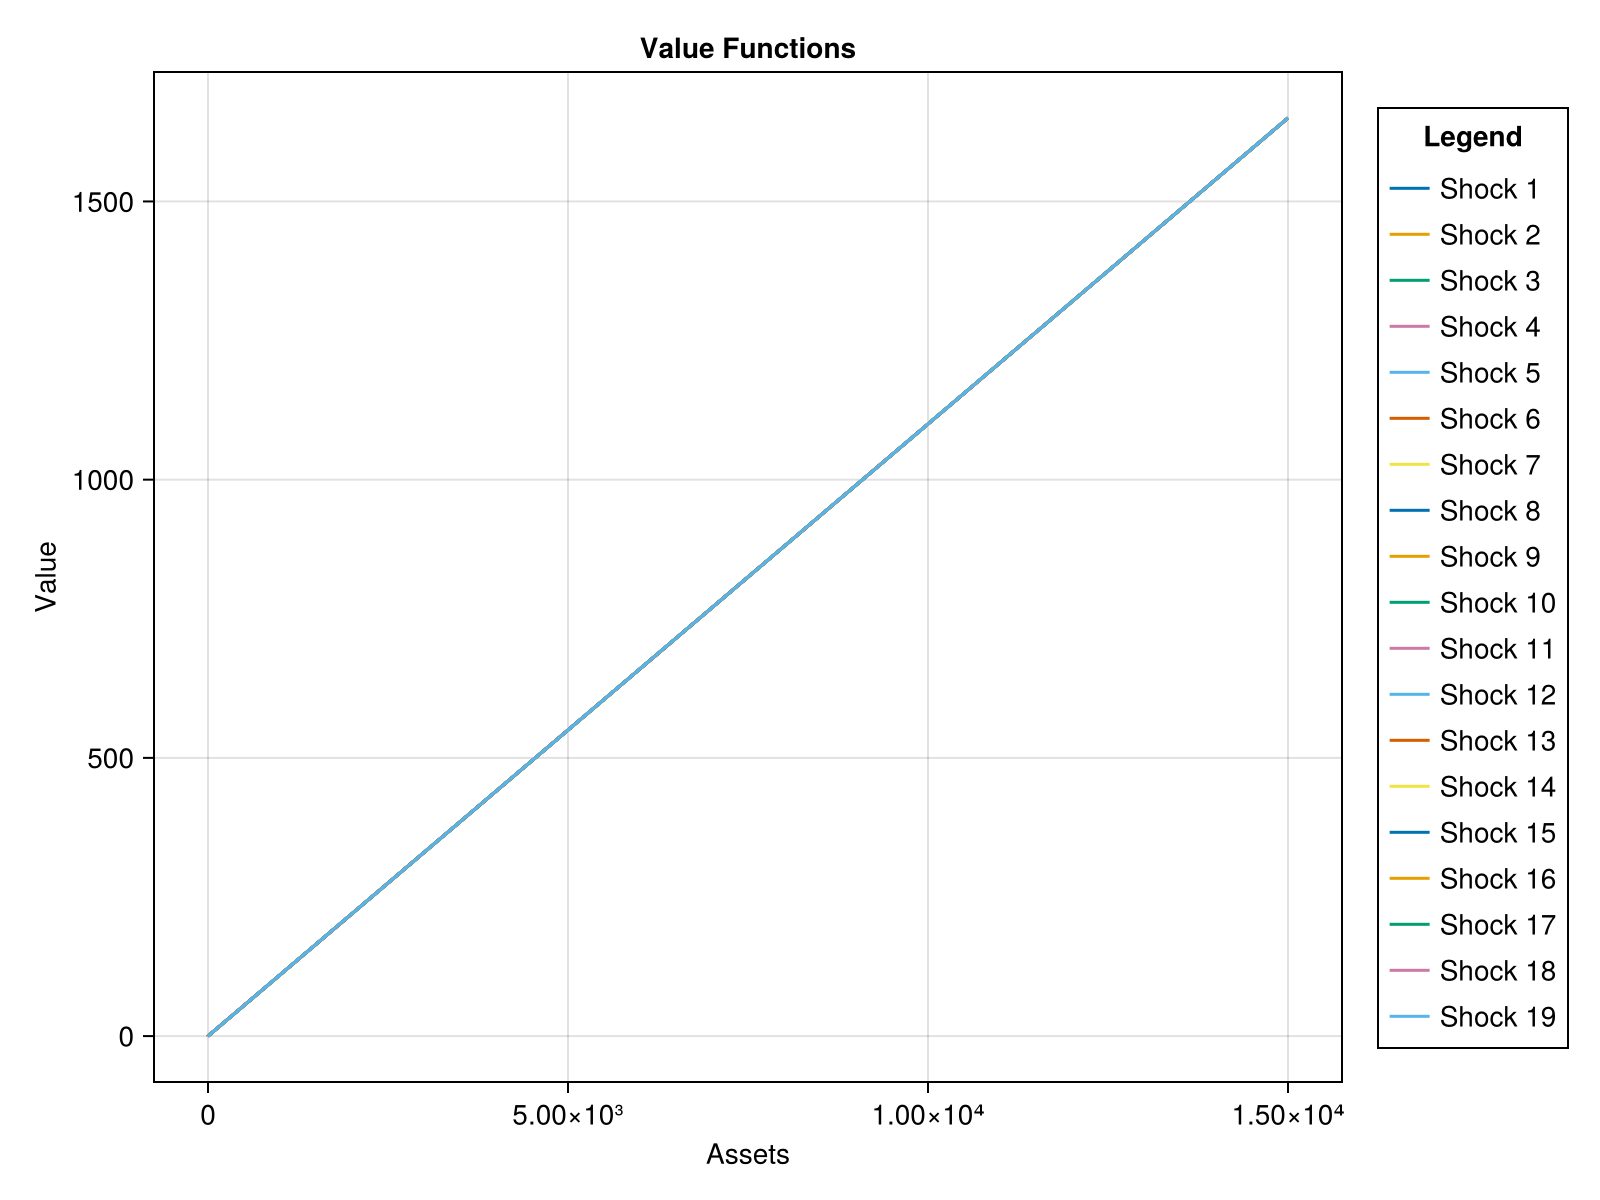

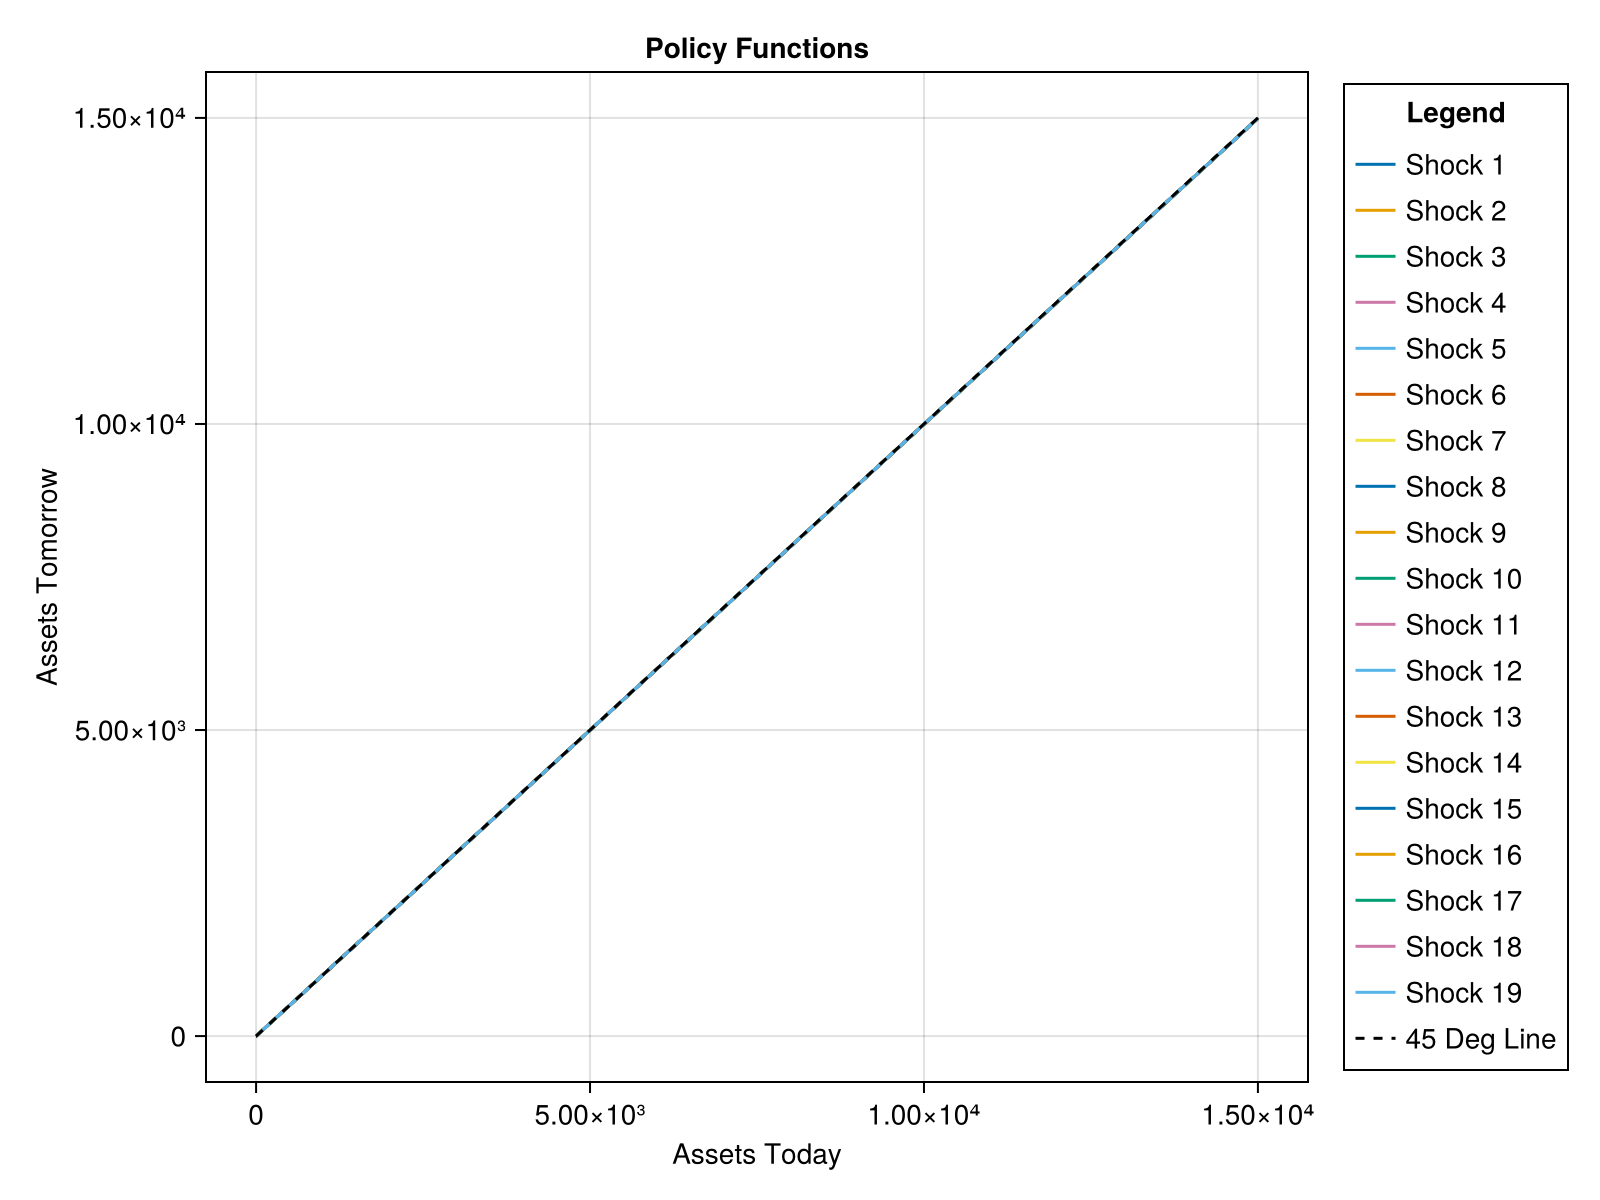

Iterating...
--------------------
Iteration: 0, Error: 3.342935293848613e-6
--------------------
Converged in 2 iterations
--------------------
  1.088660 seconds (2.56 M allocations: 137.000 MiB, 49.38% compilation time)


([0.002844878136525783 0.004050609724030426 … 0.06433278301055975 0.08786566039021602; 0.018992847090075274 0.019021851343659007 … 0.0663752234269835 0.08990810080663977; … ; 1440.8106474870324 1440.8106647927732 … 1440.8550285544648 1440.8784997081175; 1650.0578127829278 1650.0578300886689 … 1650.1021938503627 1650.1256650040157], [4.043884594224773e-16 3.820028971959754e-16 … 0.383626571931457 0.5968581534789591; 0.006148812009959374 0.0063009335856434884 … 0.4021331391386604 0.6153647213116131; … ; 13091.225705664374 13091.225862533682 … 13091.628958711235 13091.842221150857; 14992.478069351739 14992.478226779927 … 14992.881322956404 14993.094585396588])

In [11]:
function hpi_CES(v_init, p)
    (; maxiter, toler, nz, na, print_skip) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        v_new = howard_CES(v_new, policy, Π, Avals, Zvals, p)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

@time begin
    hpi_v_CES, hpi_pol_CES = hpi_CES(v2, p)
end    